<a href="https://colab.research.google.com/github/Richard-Shimada/food-sales-predictions/blob/main/Project_1_Final_(Core)_RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
#import libraries and load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import set_config
set_config(display='diagram')

df = pd.read_csv('/content/drive/MyDrive/Coding Dojo 2022/05 Week 5: Intro to Machine Learning and Pre-Processing/sales_predictions_original.csv')
sales_df = df.copy()
sales_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [47]:
# Create a function to take the true and predicted labels and print MAE, MSE, RMSE, and R2 metrics
def evaluate_regression(y_true, y_pred):
  """Takes true target and predicted target and prints MAE, MSE, RMSE and R2"""
  
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)

  print(f'scores: \nMAE: {mae:,.2f} \nMSE: {mse:,.2f} \nRMSE: {rmse:,.2f} \nR2: {r2:.2f}')

In [48]:
#no duplicates
sales_df.duplicated().sum()



0

In [49]:
#change all values to Low Fat or Regular. Will ordinal encode assuming that the average consumer will be health conscious where possible, can also see the one hot encode point of view one is not inherently better than the other in terms of predicting sales
sales_df['Item_Fat_Content'].value_counts()
sales_df['Item_Fat_Content'].replace({'Low Fat':0,'LF':0,'low fat':0,'Regular':1,'reg':1},inplace=True)
sales_df['Item_Fat_Content'].value_counts()

0    5517
1    3006
Name: Item_Fat_Content, dtype: int64

In [50]:
sales_df['Outlet_Identifier'].nunique()
#sales_df.shape

10

In [51]:
# Identifying the features (X) and target (y): "Item_Outlet_Sales" column is the target; dropped Item_Identifier and Outlet_Identifier from the features matrix as they are just IDs that wouldn't have any predicting power 

X = sales_df.drop(['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales'],axis=1)
y = sales_df['Item_Outlet_Sales']

In [52]:
# Perform a train test split 
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [53]:
# Create a preprocessing object to prepare the dataset for Machine Learning
categorical_columns = make_column_selector(dtype_include='object')
numeric_columns = make_column_selector(dtype_include='number')

In [54]:
#Need to address null values in Item_weight and Outlet_Size
X_train.isna().sum()

Item_Weight                  1107
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Establishment_Year       0
Outlet_Size                  1812
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [55]:

#X_train['Item_Weight'].nunique()
#Since item weight is continuous and has many different values,  we will use the mean to impute values

#For rows where Outlet_Size is not null,Outlet_Location_Type of Tier 2 only appears in Outlet_Size of Small, same for Outlet_Type = Grocery Store.
#For all rows where Outlet_Size is null, values of either Tier 2 or Grocery are in each row! So we will impute the NaN to Small
#X_train['Outlet_Size'].value_counts()
#X_train.groupby(['Outlet_Size','Outlet_Location_Type','Outlet_Type'],dropna=False)['Item_MRP'].sum()



In [56]:
#instantiate scalar and ohe
#For imputing, using the ‘mean’ strategy for Item_Weight and the constant(Small) strategy for Outlet_Size
constant_imputer = SimpleImputer(strategy='constant',fill_value='Small')
mean_imputer = SimpleImputer(strategy='mean')
# Scaler
scaler = StandardScaler()
# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [57]:
numeric_pipeline = make_pipeline(mean_imputer,scaler)
numeric_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [58]:
categorical_pipeline = make_pipeline(constant_imputer,ohe)
categorical_pipeline

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='Small', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [59]:
# Tuples for Column Transformer
number_tuple = (numeric_pipeline, numeric_columns)
category_tuple = (categorical_pipeline, categorical_columns)
# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f10739f50d0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Small',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f10739f5c90>)])

In [60]:
#fit train data to column transformer and then transform data

preprocessor.fit(X_train)

X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [61]:
#resulting numpy array
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (6392, 31)




array([[ 0.81724868, -0.7403206 , -0.71277507, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.5563395 ,  1.35076614, -1.29105225, ...,  0.        ,
         1.        ,  0.        ],
       [-0.13151196,  1.35076614,  1.81331864, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.11373638, -0.7403206 , -0.92052713, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.76600931, -0.7403206 , -0.2277552 , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.81724868, -0.7403206 , -0.95867683, ...,  1.        ,
         0.        ,  0.        ]])

In [62]:
#fit processed data to linear regression model and evaluate

linear_reg = LinearRegression()
linear_reg.fit(X_train_processed,y_train)

linear_reg_train_score = linear_reg.score(X_train_processed,y_train)
linear_reg_test_score = linear_reg.score(X_test_processed,y_test)


print('Training')
evaluate_regression(y_train, linear_reg.predict(X_train_processed))
print ('\n')
print('Testing')
evaluate_regression(y_test, linear_reg.predict(X_test_processed))

#results show model with low bias (based on error metrics) and low variance (R2 for the training and test sets are very close)


Training
scores: 
MAE: 847.59 
MSE: 1,298,900.53 
RMSE: 1,139.69 
R2: 0.56


Testing
scores: 
MAE: 805.00 
MSE: 1,196,253.16 
RMSE: 1,093.73 
R2: 0.57


In [63]:
#fit processed data to linear regression model and evaluate
reg_tree = DecisionTreeRegressor(random_state=42)
reg_tree.fit(X_train_processed,y_train)


print('Training')
evaluate_regression(y_train, reg_tree.predict(X_train_processed))
print ('\n')
print('Testing')
evaluate_regression(y_test, reg_tree.predict(X_test_processed))

#results show high variance in the model. R2 is 1.0 which is very good, but the model does not perform well on the test data set (R2 of 0.2). We need to tune this model.

Training
scores: 
MAE: 0.00 
MSE: 0.00 
RMSE: 0.00 
R2: 1.00


Testing
scores: 
MAE: 1,039.67 
MSE: 2,202,384.66 
RMSE: 1,484.04 
R2: 0.20


In [64]:
# 1. Run a regression tree model with default parameters (unlimited depth).
# 2. Determine the depth of the default tree.
reg_tree.get_depth()

40

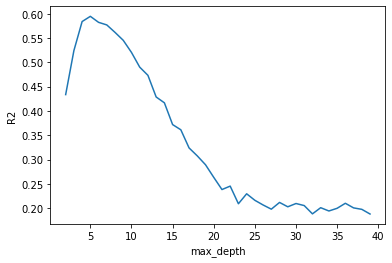

In [68]:
# List of values to try from-rainbow">for max_depth:
depths = list(range(2, 40)) # will try every value between 2 and 40
# Data frame to store the score for each value of max_depth:
scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])
for depth in depths:
    reg_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    reg_tree.fit(X_train_processed, y_train)
    train_score = reg_tree.score(X_train_processed, y_train)
    test_score = reg_tree.score(X_test_processed, y_test)
    scores.loc[depth, 'Train Score'] = train_score
    scores.loc[depth, 'Test Score'] = test_score

plt.plot(depths, scores['Test Score'])
plt.xlabel('max_depth')
plt.ylabel('R2');



In [66]:
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()

,Test Score,Train Score
5,0.59471,0.60394
4,0.584005,0.582625
6,0.582356,0.615072
7,0.577047,0.626449
8,0.56169,0.64275


In [67]:
# 4. What is the r2 of your final model on the training set and on the test set?

# Let's run the model with our optimized value for max_depth
reg_tree_5 = DecisionTreeRegressor(max_depth = 5, random_state = 42)
reg_tree_5.fit(X_train_processed, y_train)


print('Training')
evaluate_regression(y_train, reg_tree_5.predict(X_train_processed))
print ('\n')
print('Testing')
evaluate_regression(y_test, reg_tree_5.predict(X_test_processed))

#After tuning, the results show a model with low bias (based on error metrics) and low variance (R2 for the training and test sets are very close)

Training
scores: 
MAE: 762.61 
MSE: 1,172,122.77 
RMSE: 1,082.65 
R2: 0.60


Testing
scores: 
MAE: 738.32 
MSE: 1,118,185.97 
RMSE: 1,057.44 
R2: 0.59


Both models have low bias and variance and preform similarly but I would choose the tuned regression tree model as it has a higher R2 value and lower MAE/MSE/RMSE values.